# Table of contents 
- [Setup](#setup) 
    - [Purpose](#Purpose)
    - [Libraries](#libraries)
- [Ground truth URLs and sentences](#groundtruthURLsandsentences)
- [URLs and sentences](#URLsandsentences)
    - [Process URLs](#processURLs)
    - [URLs in NeuroImage 2022 articles](#URLsinNeuroImage2022articles)
- [Investigation](#investigation)
- [References](#references) 

<a name='setup'></a>
# 0. Setup 

This notebook contains the code to extract the datasets used in the articles published in NeuroImage in 2022. 
<br>
<br>

<a name='purpose'></a> 
## 0.1. Purpose
This notebook is one of a few whose purpose is to locate and extract publicly available datasets used for analysis in the research articles published in NeuroImage in 2022. In this specific notebook, pypdf is used to read PDF's and urlextract is used to locate and extract URLs and the sentences in which the URLs appear in. 

<br>
<br>

<a name='libraries'></a>
## 0.2. Libraries 

In [22]:
import pandas as pd
import numpy as np

import json 
import os 
import re 
import io

# Read PDFs
import pypdf 
# Extract URLs from text 
import urlextract 

# Random 
import random

# Plot and figures 
import matplotlib.pyplot as plt

# 1. Ground truth URLs and sentences 
<a name = 'groundtruthURLsandsentences'></a>

Based on my exploration of ten randomly picked articles, 75% of the articles contained URLs - of the articles that did not contain any URLs, the majority either used self-collected data or no datasets at all. This means that extracting the URLs will also extract the datasets used for analysis in the article. 


I will test the functions using the groundtruth texts as my validation set. When manually extracting the datasets from the ten groundtruth texts, we should get the following datasets (NB! Currently, I have not distinguished between links that leads the reader to data and links that leads the reader to code - this will come later): 


Similar to my processing, I will perform the following manually: 
- For each article, save only unique URLs (i.e., if the same URL is mentioned more than one time, save all the sentences in one list) 
- Remove the following URLs: 
    - 'www.elsevier.com/locate/neuroimage'
    - URLs containing the DOI of the article
    - Creative Commons licenses
- Columns: 
    - DOI: The article's DOI
    - URL: The URL
    - Sentence: The sentence(s) in which the URL appears. The only cleaning I did included removing extra spaces, e.g., 'under- lay' is changed to 'under-lay'. 
    - Data: True if the URL and sentence(s) point to and describe a dataset. 

In [2]:
# List of groundtruth DOI values to filter 
groundtruth_dois = [
    '10.1016/j.neuroimage.2021.118839',
    '10.1016/j.neuroimage.2021.118854',
    '10.1016/j.neuroimage.2022.119030',
    '10.1016/j.neuroimage.2022.119050',
    '10.1016/j.neuroimage.2022.119240',
    '10.1016/j.neuroimage.2022.119443',
    '10.1016/j.neuroimage.2022.119526',
    '10.1016/j.neuroimage.2022.119549',
    '10.1016/j.neuroimage.2022.119646',
    '10.1016/j.neuroimage.2022.119676',
] 

In [3]:
groundtruth_urls = [
    {
        'DOI': '10.1016/j.neuroimage.2021.118839',
        'URL': 'http://neuroimage.usc.edu/brainstorm',
        'Sentence': ['Subsequently the results were loaded in a Matlab Tool Box, Brainstorm (Tadel et al. 2011), an accredited software freely available for download online under the GNU general public license (http://neuroimage.usc.edu/brainstorm).'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2021.118854',
        'URL': 'https://www.humanconnectome.org/study/hcp-young-adult/data-releases',
        'Sentence': ['We applied our GFA extension to the publicly available resting-state functional MRI (rs-fMRI) and non-imaging measures (e.g., demograph-ics, psychometrics and other behavioural measures) obtained from 1003 subjects (only these had rs-fMRI data available) of the 1200-subject data release of the HCP (https://www.humanconnectome.org/study/hcp-young-adult/data-releases).'],
        'Label': 'Dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2021.118854',
        'URL': 'https://www.humanconnectome.org/study/hcp-young-adult/document/extensively-processed-fmri-data-documentation',
        'Sentence': ['The data used in this study was downloaded from the Human Connectome Project website (https://www.humanconnectome.org/study/hcp-young-adult/document/extensively-processed-fmri-data-documentation).'],
        'Label': 'Dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2021.118854',
        'URL': 'https://github.com/ferreirafabio80/gfa',
        'Sentence': ['The GFA models and experiments were implemented in Python 3.9.1 and are available here: https://github.com/ferreirafabio80/gfa.'],
        'Label': 'Model'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119030',
        'URL': 'marmosetbrainconnectome.org',
        'Sentence': ['To accelerate such progress, we present the Marmoset Functional Brain Connectivity Resource (marmosetbrainconnectome.org), currently consisting of over 70 h of resting-state fMRI (RS-fMRI) data acquired at 500 μm isotropic resolution from 31 fully awake marmosets in a common stereotactic space.', 'To promote progress in understanding the functional organization of the marmoset brain, we present a resource that allows for online viewing and download of three-dimensional functional connectivity (FC) maps from over 70 h of RS-fMRI collected at ultra-high field from 31 fully awake adult marmosets: marmosetbrainconnectome.org.', 'A resampled ver-sion of this atlas (at 100 μm) allows for additional anatomical detail over the in vivo template but will still load sufficiently fast as an under-lay image on marmosetbrainconnectome.org.', 'Features of the web portal: marmosetbrainconnectome.org.', 'The Marmoset Functional Connectivity Resource is publicly accessi-ble at marmosetbrainconnectome.org.', 'This resource allows users to instantaneously view and use FC topologies from any gray matter voxel in the marmoset brain online (marmosetbrainconnectome.org; Fig. 1), offering a fine-grained (500 μm) insight into how the marmoset brain is functionally con-nected in any given region, utterly agnostic to structural nomenclature.', 'Tracer maps (B & E) were downloaded from marmosetbrain.org, and FC maps (A through H) were generated from marmosetbrainconnectome.org.', 'With all the publicly available data demo-graphics, users can also download specific demographics (e.g., heavy males in late life) to address their research questions. Individual-level topologies can be loaded via the marmosetbrainconnectome.org viewer without any analysis.'],
        'Label': 'Dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119030',
        'URL': 'https://www.marmosetbrainconnectome.org/download.html',
        'Sentence': ['(B) The data download page (https://www.marmosetbrainconnectome.org/download.html) allows the user to download all raw (BIDS standard formated) (Gorgolewski et al., 2016) and pre-processed data.', 'Directing to https://www.marmosetbrainconnectome.org/download.html allows for download of the “raw” structural and functional images (3D Neu-roimaging Informatics Technology Initiative (NIfTI) format) contribut-ing to the FC maps shown in the resource – for convenience, these data are in a standard format (BIDS) (Gorgolewski et al., 2016).', 'All raw and preprocessed data are openly available for download at: https://www.marmosetbrainconnectome.org/download.html'],
        'Label': 'Dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119030',
        'URL': 'https://rii-mango.github.io/Papaya/',
        'Sentence': ['The resource makes use of the Papaya viewer (https://rii-mango.github.io/Papaya/), with several additional features (illustrated in Fig. 1C & D), including (1) calculation of surface over-lay maps on-demand based on the threshold chosen in volume space, (2) the ability to display atlas borders in surface space, (3) support for rotating the underlying volume, overlaying functional connectiv-ity map, and atlas boundaries together – such obliquing of the images can be of utility for presurgical planning, and (4) the ability to choose between group- and subject-level topologies.'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119030',
        'URL': 'https://gitlab.com/cfmm/marmoset',
        'Sentence': ['The development of the Marmoset Functional Connectivity Resource is described in full detail at https://gitlab.com/cfmm/marmoset.', 'All code for the online viewer is available at: https://gitlab.com/cfmm/marmoset'],
        'Label': 'Code'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119030',
        'URL': 'https://gitlab.com/cfmm/marmoset-connectivity',
        'Sentence': ['Users can also download all code used to generate the functional connectivity maps from https://gitlab.com/cfmm/marmoset-connectivity.', 'A 3D printed model is shown in stereotactic position (with skull cut away to expose the cortical surface) to demonstrate targeting based on the resource coordinates. (D) in method 2, the user employs the supplied code (downloaded from https://gitlab.com/cfmm/marmoset-connectivity) to transform the FC map to their native animals’ anatomical MRI space.', 'All code used for processing data is openly available at: https://gitlab.com/cfmm/marmoset-connectivity'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119030',
        'URL': 'marmosetbrain.org',
        'Sentence': ['Explicitly, we focused on a tracer map from an area 46 injection (left; CJ801-DY; marmosetbrain.org for notes on these injections).', 'To demonstrate the additional information offered by our resource, we systematically plotted connectivity across (within) area TE3 for com-parison with available tracer injections within that region (left; CJ180- CTBr and CJ180-DY; marmosetbrain.org for notes on these injections) (Majka et al., 2020).', 'As shown in Fig. 9, we systematically plotted connectivity across (within) area TE3 and compared available tracer injections within that region (left; CJ180-CTBr and CJ180-DY; marmosetbrain.org for notes on these injections) (Majka et al., 2020).', 'Green labeled ROIs indicate FC data, whereas purple labeled ROIs show where tracer data is publicly available within area TE3 from marmosetbrain.org', 'Accordingly, these re-sources can readily perform similar comparisons in any circuitry of inter-est Fig. 9. shows an example of how our brain-wide functional connec-tivity data can complement existing resources (e.g., marmosetbrain.org) (Majka et al., 2020), demonstrating a gradient of connectivity between cortical tracer injection sites.'],
        'Label': 'Atlas/map'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119050',
        'URL': 'http://audition.ens.fr/adc/NoiseTools/',
        'Sentence': ['EEG analysis used FieldTrip (Oostenveld et al., 2011), Noise-Tools (De Cheveigne and Parra, 2014; http://audition.ens.fr/adc/NoiseTools/), and custom-written scripts in Matlab.'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119050',
        'URL': 'zenodo.org',
        'Sentence': ['Raw EEG data from all healthy individuals, as well as Matlab code, are publicly available on zenodo.org (doi:10.5281/zenodo.6110595).'],
        'Label': 'Dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119240',
        'URL': 'www.cni.stanford.edu',
        'Sentence': ['MRI data were acquired on a 3T Discovery MR750 scanner (Gen-eral Electric Healthcare, Milwaukee, WI, USA) equipped with a 32-channel head coil (Nova Medical, Wilmington, MA, USA) at the Cen-ter for Cognitive and Neurobiological Imaging at Stanford Univer-sity (www.cni.stanford.edu).'],
        'Label': 'Resource'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119240',
        'URL': 'http://github.com/vistalab/vistasoft/mrDiffusion',
        'Sentence': ['Diffusion weighted images were pre-processed with Vistasoft (http://github.com/vistalab/vistasoft/mrDiffusion), an open-source software package implemented in MATLAB R2012a (Mathworks, Natick, MA).'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119240',
        'URL': 'http://www.fil.ion.ucl.ac.uk/spm/',
        'Sentence': ['Each diffusion weighted image was registered to the mean of the b=0 images and the mean b=0 image was registered automatically to the participant’s T1w image, using a rigid body transformation (imple-mented in SPM8, http://www.fil.ion.ucl.ac.uk/spm/; no warping was applied).'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119240',
        'URL': 'https://github.com/mezera/mrQ',
        'Sentence': ['Quantitative T1 (relaxation time, seconds) maps were calculated us-ing mrQ, (https://github.com/mezera/mrQ), an open-source software package implemented in MATLAB R2012a (Mathworks, Natick, MA).'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119240',
        'URL': 'https://github.jyeatman/AFQ',
        'Sentence': ['Automated Fiber Quantification (AFQ; https://github.jyeatman/ AFQ; (Yeatman, Dougherty, Myall, et al., 2012)), a software package implemented in MATLAB R2012a (Mathworks, Natick, MA), was used to isolate and characterize white matter metrics from three dorsal tracts (Arc-L and bilateral SLF) and four ventral white matter tracts (bilat-eral ILF and bilateral UF).'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119443',
        'URL': 'osf.io/gazx2/',
        'Sentence': ['EEG datasets used to create the figure in this commentary are freely available at osf.io/gazx2/, osf.io/eucqf/, osf.io/thsqg/ and osf.io/bndjg/.'],
        'Label': 'Dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119443',
        'URL': 'osf.io/eucqf/',
        'Sentence': ['EEG datasets used to create the figure in this commentary are freely available at osf.io/gazx2/, osf.io/eucqf/, osf.io/thsqg/ and osf.io/bndjg/.'],
        'Label': 'Dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119443',
        'URL': 'osf.io/thsqg/',
        'Sentence': ['EEG datasets used to create the figure in this commentary are freely available at osf.io/gazx2/, osf.io/eucqf/, osf.io/thsqg/ and osf.io/bndjg/.'],
        'Label': 'Dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119443',
        'URL': 'osf.io/bndjg/',
        'Sentence': ['EEG datasets used to create the figure in this commentary are freely available at osf.io/gazx2/, osf.io/eucqf/, osf.io/thsqg/ and osf.io/bndjg/.'],
        'Label': 'Dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119443',
        'URL': 'osf.io/guwnm/',
        'Sentence': ['Code used to reproduce the plots in Fig. 1, as well as averaged ERP data, is available from osf.io/guwnm/.'],
        'Label': 'Processed dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119526',
        'URL': 'https://db.humanconnectome.org/data/projects/HCP_1200',
        'Sentence': ['200 unrelated subjects were selected from the Human Con-nectome Project (HCP) 1200 Subjects Data Release with avail-able resting (task-free) and task fMRI data from a 3T MRI scan-ner (https://db.humanconnectome.org/data/projects/HCP_1200).', 'Preprocessed task fMRI data for the four tasks from the HCP were analyzed (working memory, motor, language, emotion) (https://db.humanconnectome.org/data/projects/HCP_1200).'],
        'Label': 'Dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119526',
        'URL': 'https://www.humanconnectome.org/study/hcp-young-adult/document/wu-minn-hcp-consortium-open-access-data-use-terms',
        'Sentence': ['This study agreed to the Open Access Data Use Terms (https://www.humanconnectome.org/study/hcp-young-adult/document/wu-minn-hcp-consortium-open-access-data-use-terms) and was exempt from the UCSF IRB because investigators could not readily ascertain the identities of the individuals to whom the data belonged.'],
        'Label': 'Resource'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119526',
        'URL': 'https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/',
        'Sentence': ['We used FSL (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/) and AFNI (https://afni.nimh.nih.gov/) for additional fMRI preprocessing.'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119526',
        'URL': 'https://afni.nimh.nih.gov/',
        'Sentence': ['We used FSL (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/) and AFNI (https://afni.nimh.nih.gov/) for additional fMRI preprocessing.'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119526',
        'URL': 'http://www.brainnetome.org/',
        'Sentence': ['Maps were averaged within 273 regions of interest by combining a parcella-tion of 210 cortical regions and 36 subcortical regions from the Brainnetome atlas (Fan et al., 2016) (http://www.brainnetome.org/) and 27 cerebellar regions from the SUIT atlas (Diedrichsen, 2006) (http://www.diedrichsenlab.org/imaging/suit.htm).'],
        'Label': 'Atlas/map'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119526',
        'URL': 'http://www.diedrichsenlab.org/imaging/suit.htm',
        'Sentence': ['Maps were averaged within 273 regions of interest by combining a parcella-tion of 210 cortical regions and 36 subcortical regions from the Brainnetome atlas (Fan et al., 2016) (http://www.brainnetome.org/) and 27 cerebellar regions from the SUIT atlas (Diedrichsen, 2006) (http://www.diedrichsenlab.org/imaging/suit.htm).'],
        'Label': 'Atlas/map'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119526',
        'URL': 'https://www.fil.ion.ucl.ac.uk/spm/software/spm12/',
        'Sentence': ['Task condition block regressors were convolved with a hemo-dynamic response function using the ‘spm_get_bf’ function in SPM12 (https://www.fil.ion.ucl.ac.uk/spm/software/spm12/).'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119526',
        'URL': 'https://github.com/rmarkello/abagen',
        'Sentence': ['We compared each gradient map to Allen Human Brain spatial gene expression patterns using the ‘abagen’ package (https://github.com/rmarkello/abagen) (Arnatkevici ̆ūtė et al., 2019; Hawrylycz et al., 2012).'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119526',
        'URL': 'https://brainsmash.readthedocs.io/en/latest/',
        'Sentence': ['These surrogate gradient maps were estimated using BrainSMASH (https://brainsmash.readthedocs.io/en/latest/).'],
        'Label': 'Atlas/map'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119526',
        'URL': 'https://sites.google.com/site/bctnet/',
        'Sentence': ['Graph the-ory analyses were run using the Brain Connectivity Toolbox (BCT; https://sites.google.com/site/bctnet/).'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119526',
        'URL': 'http://human.brain-map.org/',
        'Sentence': ['Original data was obtained from the Human Connectome Project (1U54MH091657, PIs Van Essen and Ugurbil) and the Allen Hu-man Brain Atlas (http://human.brain-map.org/).'],
        'Label': 'Atlas/map'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119526',
        'URL': 'https://github.com/jbrown81/gradients',
        'Sentence': ['All code (latent space derivation, dynamical system modeling, and gene expression corre-lation) and processed data (gradient maps/region weights, gradient timeseries, and region gene expression values) are available at https://github.com/jbrown81/gradients.', 'All code and processed data are available at https://github.com/jbrown81/gradients.'],
        'Label': 'Processed dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119549',
        'URL': np.nan,
        'Sentence': np.nan,
        'Label': np.nan
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119646',
        'URL': np.nan,
        'Sentence': np.nan,
        'Label': np.nan
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119676',
        'URL': 'https://www.shutterstock.com',
        'Sentence': ['Both experiments employed static images (modified from Shutterstock, https://www.shutterstock.com).'],
        'Label': 'Resource'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119676',
        'URL': 'https://clippingmagic.com',
        'Sentence': ['All image transformations were done with Clipping Magic (https://clippingmagic.com), ImageMagick, GIMP, Microsoft Paint, the MATLAB SHINE toolbox, and custom MATLAB code.'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119676',
        'URL': 'http://www.nitrc.org/projects/jip',
        'Sentence': ['Functional volumes were realigned and motion-corrected with the Statistical Parametric Mapping software (SPM12, RRID: SCR_007037), followed by non-rigid co-registration (using JIP, http://www.nitrc.org/projects/jip, RRID: SCR_009588) to the high-resolution anatomical template of the skull-stripped brain of each monkey.'],
        'Label': 'Software'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119676',
        'URL': 'https://caffe.berkeleyvision.org/model_zoo.html',
        'Sentence': ['Another version of pre-trained AlexNet was im-ported from Caffe Model Zoo (https://caffe.berkeleyvision.org/model_zoo.html).'],
        'Label': 'Model'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119676',
        'URL': 'https://osf.io/b8pfa/?view_only=b6dbb5dd6a044989a7eecdc99facb43c',
        'Sentence': ['Preprocessed fMRI data are available at https://osf.io/b8pfa/?view_only=b6dbb5dd6a044989a7eecdc99facb43c.'],
        'Label': 'Preprocessed dataset'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119676',
        'URL': 'https://github.com/Yozafirova/monkey-fMRI-codes',
        'Sentence': ['Codes for the fMRI data analysis at https://github.com/Yozafirova/monkey-fMRI-codes and for the CNN data analysis at https://github.com/RajaniRaman/face_body_integration.'],
        'Label': 'Analysis'
    },
    {
        'DOI': '10.1016/j.neuroimage.2022.119676',
        'URL': 'https://github.com/RajaniRaman/face_body_integration',
        'Sentence': ['Codes for the fMRI data analysis at https://github.com/Yozafirova/monkey-fMRI-codes and for the CNN data analysis at https://github.com/RajaniRaman/face_body_integration.'],
        'Label': 'Analysis'
    },
]

# Convert the list of dictionaries to a DataFrame
manual_groundtruth_urls = pd.DataFrame(groundtruth_urls)

In [4]:
# Path to the 'Data' directory
data_dir = os.path.join(os.pardir, 'Data')

# File path
file_path = os.path.join(data_dir, 'articles_groundtruth_urls_and_sentences.csv')

# Save the DataFrame to CSV, overwriting the file if it exists
manual_groundtruth_urls.to_csv(file_path, index=False, mode='w')

In [5]:
manual_groundtruth_urls.count()

DOI         43
URL         41
Sentence    41
Label       41
dtype: int64

In [6]:
# Check for NaN values in the 'URL' column
manual_groundtruth_urls[manual_groundtruth_urls['URL'].isna()]

,DOI,URL,Sentence,Label
34,10.1016/j.neuroimage.2022.119549,NaN,NaN,NaN
35,10.1016/j.neuroimage.2022.119646,NaN,NaN,NaN


In [7]:
len(manual_groundtruth_urls[manual_groundtruth_urls['Label']==True])

0

In [8]:
# Group by 'DOI' and count the number of URLs, setting NaN counts to 0
url_counts = manual_groundtruth_urls.groupby('DOI')['URL'].count().fillna(0)

# Sort the counts in descending order
url_counts = url_counts.sort_values(ascending=False)

url_counts

DOI
10.1016/j.neuroimage.2022.119526    12
10.1016/j.neuroimage.2022.119676     7
10.1016/j.neuroimage.2022.119030     6
10.1016/j.neuroimage.2022.119240     5
10.1016/j.neuroimage.2022.119443     5
10.1016/j.neuroimage.2021.118854     3
10.1016/j.neuroimage.2022.119050     2
10.1016/j.neuroimage.2021.118839     1
10.1016/j.neuroimage.2022.119549     0
10.1016/j.neuroimage.2022.119646     0
Name: URL, dtype: int64

A total of 41 links were extracted manually from the groundtruth articles. There are between one and twelve URLs in the articles. Two of the articles did not contain any URLs. 20 of the 41 links point of data/datasets, models pretrained with data. 

<a name='URLsandsentences'></a>
# 2. URLs and sentences
I use the work of Sourget (2023) to search the PDFs for their datasets: 

I use the Python library *urlextract* by Lipovský (2022) to extract the URLs. 

I perform some initial cleaning of the sentences extracted from the PDFs, specifically removing multiple spaces with a single space, removing all \n characters, and remove leadning and trailing spaces after a number of special characters, incl. -, (, ), /, ., _ , and between : /.

The functions: 
- *get_content* is losely interpreted from Soruget (2023) using the following breadcrumb in the github repository: DDSA_Sourget/code/other/download_fulltext.ipynb, section '3. Check for dataset's organ in figures'.
- *clean_text* 
- *split_text_into_sentence* 
- *extract_links* uses the urlextract library (Lipovský 2022). 
- *get_urls_and_sentences* calls on *extract_links* and gets both URLs and sentences containing the URL. 
- *extract_and_transform_urls_from_dataframe* 
    

<br>

References: 
- Lipovský, J. (2022). urlextract: Collects and extracts URLs from given text. (1.8.0) [Python]. https://github.com/lipoja/URLExtract
- Sourget, T. (2023). TheoSourget/DDSA_Sourget: Repository used during my travel at the ITU of Copenhagen in March 2023 [Computer software]. https://github.com/TheoSourget/DDSA_Sourget

In [9]:
def get_content(pdf_path, alt_pdf_path):
    """Get sentences that contain URLs. 
    This function is loosely interpreted from Sourget, T. (2023). TheoSourget/DDSA_Sourget: Repository used during my travel at the ITU of Copenhagen in March 2023 [Computer software]. https://github.com/TheoSourget/DDSA_Sourget
    specifically: DDSA_Sourget/code/other/download_fulltext.ipynb, section '3. Check for dataset's organ in figures'.
    
    Parameters: 
    :param pdf_path (str): Path to the PDF file.
    :param alt_pdf_path (str): Alternative path to the PDF file. 
    
    Returns: 
    :return: Dataframe or 'Editorial board' if not found.
    """
    try:
        pdf_file = open(pdf_path, 'rb')
        pdf_reader = pypdf.PdfReader(pdf_file)
        pdf_text = " ".join(page.extract_text() for page in pdf_reader.pages)

        # Extract sentences containing urls
        df = get_urls_and_sentences(pdf_text)
        pdf_file.close()
        if df is not None:  # Check if a DataFrame is returned
            return df

    except FileNotFoundError:
        try:
            alternative_pdf_path = os.path.join(alt_pdf_path, os.path.basename(pdf_path))
            pdf_file = open(alternative_pdf_path, 'rb')
            return pd.DataFrame({"url": [np.nan], "sentences": [np.nan]})
        except FileNotFoundError:
            return pd.DataFrame({"url": [np.nan], "sentences": [np.nan]})
        except Exception as e:
            print(f"Error reading PDF: {e}")
    
    except Exception as e:
        print(f"Error reading PDF: {e}")
    
    # If no URLs were found, return an empty DataFrame
    return pd.DataFrame(columns=["url", "sentences"])


############### SENTENCES ################################################
def clean_text(text): 
    """This function performs a very simple initial cleaning of the extracted sentences. 
    This includes removing multiple spaces with a single space, removing all \n characters, 
    and remove leadning and trailing spaces after a number of special characters, 
    incl. -, (, ), /, ., _ , and between : / 

    Parameters: 
    :param text(str): Input text in the form of a string. 

    Returns: 
    :return text(str): Returns the cleaned text.
    """
    return text.replace('   ', ' ').replace('  ', ' ').replace('\n', '').replace('- ', '-').replace('( ', '(').replace(' )', ')').replace('/ ', '/').replace(' /', '/').replace(' .', '.').replace(': /', ':/').replace(' _ ', '_').replace(' _', '_').replace('_ ', '_') 

def get_sentences(text):
    """This function splits a given text into sentences based on a regular expression pattern. 
    It uses re.split() to identify sentence boundaries, considering common sentence-ending 
    punctuation like ".", "!", or "?". It avoids splitting sentences if a digit immediately 
    follows the punctuation, e.g., 'Fig. 1'. 
    
    Parameters: 
    :param text(str): Input text in the form of a string. 
    
    Returns: 
    :return sentences(list): Returns the text as a list of sentences.  
    """
    sentence_pattern = r'(?<=[.!?])\s+(?![0-9]+\s)'
    sentences = re.split(sentence_pattern, text)
    return sentences


############### LINKS ################################################
def get_urls(text):
    """This function returns all unique urls in a text that have certain characters stripped from 
    the end of them (including ',', '.', and ')'). It uses the Python library URLExtract (Lipovský 2022).

    Parameters: 
    :param text(str): Input text that may or may not contain a URL. 

    Returns: 
    :returns unique_urls_list(list): List of unique URLs from a given text. 
    """
    # Instance of the URLExtract class
    extractor = urlextract.URLExtract()
    
    # Create a set to store unique URLs
    unique_urls = set()
    
    for url in extractor.gen_urls(text):
        # Apply additional processing to the URL, e.g., removing characters at the end
        processed_url = url.rstrip('.').rstrip(')').rstrip(',')
        unique_urls.add(processed_url)
    
    # Convert the set back to a list if needed
    unique_url_list = list(unique_urls)
    
    return unique_url_list

def get_sentences_with_urls(sentences):
    """This function returns all text that contains URLs. It uses the Python library URLExtract (Lipovský 2022).

    Parameters: 
    :param sentences(list): Input text from a list containing sentences. 

    Returns: 
    :returns sentences_with_urls(list): List of sentences containing URLs. 
    """
    # Instance of the URLExtract class
    extractor = urlextract.URLExtract()
    # Extract all sentences with URLs
    sentences_with_urls = []
    stop_processing = False  # Flag to stop processing when "References" is found

    for sentence in sentences:
        if stop_processing:
            break  # Stop processing when "References" is found
        if extractor.has_urls(sentence):
            sentences_with_urls.append(sentence)
        if "References" in sentence:
            stop_processing = True  # Set the flag to stop processing

    return sentences_with_urls
    
def get_urls_and_sentences(text):
    """This function extracts URLs and their corresponding sentences from the given text. 
    If no URLs are found, an empty DataFrame with columns ["url", "sentences"] is returned.

    Parameters:
    :param text (str): Input text containing URLs and sentences.

    Returns:
    :returns pd.DataFrame: A DataFrame with two columns, 'url' and 'sentences'.
      Each row represents a URL along with a list of sentences containing that URL.
    """
    # Lists to store the extracted URLs and their corresponding sentences
    url_list = []
    sentence_list = []
    # Clean sentences 
    cleaned_text = clean_text(text)
    # Extract links
    links = get_urls(cleaned_text)
    # Extract sentences 
    sentences = get_sentences(cleaned_text)
    # Extract sentences with links 
    sentences_w_links = get_sentences_with_urls(sentences)

    # Process each URL 
    for link in links:
        sentences_for_url = [sentence for sentence in sentences_w_links if link in sentence]
        if sentences_for_url:  # Only add the URL if there are associated sentences
            url_list.append(link)
            sentence_list.append(sentences_for_url)
    
    # If no URLs were found, return an empty DataFrame
    if not url_list:
        return pd.DataFrame(columns=["url", "sentences"])

    return pd.DataFrame({"url": url_list, "sentences": sentence_list})


############### DATAFRAME WITH DOI, URL, SENTENCES ################################################
def process_groundtruth_DOIs(groundtruth_dois, articles_directory, editorialboard_directory, json_file_path):
    """This function processes a list of DOIs, extracts urls and sentences from PDFs, 
    and create a DataFrame.

    Parameters:
    :param groundtruth_dois (list): List of DOIs to process.
    :param articles_directory (str): Path to the directory containing PDF articles.
    :param editorialboard_directory (str): Path to the directory with editorial board articles.
    :param json_file_path (str): Path to a JSON file.

    Returns:
    :return pd.DataFrame: A DataFrame containing processed information from the DOIs.
    """
    results_list = []

    with open(json_file_path, 'r') as json_file:
        for doi in groundtruth_dois:
            doi_replaced = doi.replace('/', '.')
            pdf_path = os.path.join(articles_directory, f"{doi_replaced}.pdf")

            # Call the get_content function for each DOI
            url_df = get_content(pdf_path, editorialboard_directory)

            # Append the DOI to the URL DataFrame
            url_df['DOI'] = doi
            results_list.append(url_df)

        """ TO PROCESS JUST ONE DOI: 
        doi = '10.1016/j.neuroimage.2022.119030'
        doi_replaced = doi.replace('/', '.')
        pdf_path = os.path.join(articles_directory, f"{doi_replaced}.pdf")

        # Call the get_content function for each DOI
        url_df = get_content(pdf_path, editorialboard_directory)
        # Append the DOI to the URL DataFrame
        url_df['DOI'] = doi
        results_list.append(url_df)
        """
            
    # Concatenate the list of DataFrames into a single DataFrame
    results_df = pd.concat(results_list, ignore_index=True)

    # Rename the columns as needed
    results_df.rename(columns={'url': 'URL', 'sentences': 'Sentences'}, inplace=True)

    return results_df


def process_DOIs(articles_directory, editorialboard_directory, json_file_path):
    """This function processes a list of DOIs, extracts urls and sentences from PDFs, 
    and create a DataFrame.

    Parameters:
    :param articles_directory (str): Path to the directory containing PDF articles.
    :param editorialboard_directory (str): Path to the directory with editorial board articles.
    :param json_file_path (str): Path to a JSON file.

    Returns:
    :return pd.DataFrame: A DataFrame containing processed information from the DOIs.
    """
    results_list = []

    with open(json_file_path, 'r') as json_file:
        doi_data = json.load(json_file)
        for doi in doi_data['DOIs']:
            doi_replaced = doi.replace('/', '.')
            pdf_path = os.path.join(articles_directory, f"{doi_replaced}.pdf")

            # Call the get_content function for each DOI
            url_df = get_content(pdf_path, editorialboard_directory)

            # Append the DOI to the URL DataFrame
            url_df['DOI'] = doi
            results_list.append(url_df)
            
    # Concatenate the list of DataFrames into a single DataFrame
    results_df = pd.concat(results_list, ignore_index=True)

    # Rename the columns as needed
    results_df.rename(columns={'url': 'URL', 'sentences': 'Sentences'}, inplace=True)

    return results_df

In [10]:
# Path to the directory containing PDFs
articles_directory = '../Data/ElsevierAPI/downloaded_pdfs/fulltext_articles_doi/'
editorialboard_directory = '../Data/ElsevierAPI/downloaded_pdfs/fulltext_editorialboard_doi/'

# Path to the JSON file containing DOI values
json_file_path = '../Data/ElsevierAPI/downloadedPDFs_info.json'

In [11]:
automatic_groundtruth_df = process_groundtruth_DOIs(groundtruth_dois, articles_directory, editorialboard_directory, json_file_path)

In [12]:
automatic_groundtruth_df

,URL,Sentences,DOI
0,https://doi.org/10.1016/j.neuroimage.2021.118839,[Corticospinal projections has been shown also...,10.1016/j.neuroimage.2021.118839
1,www.elsevier.com/locate/neuroimage,[NeuroImage 248 (2022) 118839 Contents lists a...,10.1016/j.neuroimage.2021.118839
2,http://creativecommons.org/licenses/by-nc-nd/4.0/,[This is an open access article under the CC B...,10.1016/j.neuroimage.2021.118839
3,http://neuroimage.usc.edu/brainstorm,"[2011), an accredited software freely availabl...",10.1016/j.neuroimage.2021.118839
4,http://creativecommons.org/licenses/by/4.0/,[This is an open access article under the CC B...,10.1016/j.neuroimage.2021.118854
...,...,...,...
65,https://github.com/Yozaﬁrova/monkey-fMRI-codes,[Codes for the fMRI data analysis at https://g...,10.1016/j.neuroimage.2022.119676
66,https://github.com/RajaniRaman/face_body_integ...,[Codes for the fMRI data analysis at https://g...,10.1016/j.neuroimage.2022.119676
67,https://clippingmagic.com,[NeuroImage 264 (2022) 119676 All image transf...,10.1016/j.neuroimage.2022.119676
68,https://caﬀe.berkeleyvision.org/model_zoo.html,[Another version of pre-trained AlexNet was im...,10.1016/j.neuroimage.2022.119676


Brief exploration of the URLs extracted from the groundtruth articles. 

In [13]:
automatic_groundtruth_df.count()

URL          70
Sentences    70
DOI          70
dtype: int64

In [14]:
len(automatic_groundtruth_df)

70

In [15]:
# How many URLs are saved per DOI
doi_counts = automatic_groundtruth_df['DOI'].value_counts()

# Print the number of rows for each unique DOI
print(doi_counts)

10.1016/j.neuroimage.2022.119526    15
10.1016/j.neuroimage.2022.119676    10
10.1016/j.neuroimage.2022.119030     9
10.1016/j.neuroimage.2022.119443     8
10.1016/j.neuroimage.2022.119240     7
10.1016/j.neuroimage.2021.118854     6
10.1016/j.neuroimage.2022.119050     5
10.1016/j.neuroimage.2021.118839     4
10.1016/j.neuroimage.2022.119549     3
10.1016/j.neuroimage.2022.119646     3
Name: DOI, dtype: int64


In [16]:
# Count the rows with URLs containing 'creativecommons.org'
cc_license_count = len(automatic_groundtruth_df[automatic_groundtruth_df['URL'].str.contains('creativecommons.org')])

# Print the count
print(f"Number of rows with links to Creative Commons license: {cc_license_count}")

Number of rows with links to Creative Commons license: 10


## 2.1. Process URLs
<a name = 'processURLs'></a>

Before this point, I already performed a few preprocessing steps of the URLs: 
- in *get_urls*, I returned only unique URLs. 
- in *process_url*, I stripped URLs of the characters '.' and ')', if they were at the end of the link. 

At this point, I have only unique URLs for each DOI. But I want to remove some URLs that I know do not point to datasets. As such, this processing step is: 
* Remove URLs: 
    * 'www.elsevier.com/locate/neuroimage' - this link is placed outside of the article's text. 
    * URLs containing the DOI of the article - this link is placed outside of the article's text. 
    * Creative Commons licenses 

I want to check any links that are common between the articles to see if there are some NeuroImage or Elsevier specific links that can be removed. 

In [17]:
# Print the rows with duplicate URLs, indicating which DOIs share the same URL. 
# Check the column 'url' for duplicates using subset='url' and keep=False keeps all occurrences of the duplicates.
duplicate_urls = automatic_groundtruth_df[automatic_groundtruth_df.duplicated(subset='URL', keep=False)]

# Print the rows with duplicate URLs
duplicate_urls

,URL,Sentences,DOI
1,www.elsevier.com/locate/neuroimage,[NeuroImage 248 (2022) 118839 Contents lists a...,10.1016/j.neuroimage.2021.118839
2,http://creativecommons.org/licenses/by-nc-nd/4.0/,[This is an open access article under the CC B...,10.1016/j.neuroimage.2021.118839
4,http://creativecommons.org/licenses/by/4.0/,[This is an open access article under the CC B...,10.1016/j.neuroimage.2021.118854
7,www.elsevier.com/locate/neuroimage,[NeuroImage 249 (2022) 118854 Contents lists a...,10.1016/j.neuroimage.2021.118854
15,http://creativecommons.org/licenses/by-nc-nd/4.0/,[This is an open access article under the CC B...,10.1016/j.neuroimage.2022.119030
18,www.elsevier.com/locate/neuroimage,[NeuroImage 252 (2022) 119030 Contents lists a...,10.1016/j.neuroimage.2022.119030
21,http://creativecommons.org/licenses/by-nc-nd/4.0/,[This is an open access article under the CC B...,10.1016/j.neuroimage.2022.119050
23,www.elsevier.com/locate/neuroimage,[NeuroImage 253 (2022) 119050 Contents lists a...,10.1016/j.neuroimage.2022.119050
26,http://creativecommons.org/licenses/by-nc-nd/4.0/,[This is an open access article under the CC B...,10.1016/j.neuroimage.2022.119240
28,www.elsevier.com/locate/neuroimage,[NeuroImage 256 (2022) 119240 Contents lists a...,10.1016/j.neuroimage.2022.119240


Remove links: 

In [18]:
def filter_urls(df, urls_to_remove):
    """This function filters a DataFrame containing information about articles, removing specified URLs. 

    Parameters:
    :param df (pd.DataFrame): Input DataFrame with columns 'DOI', 'URL', and 'Sentences'.
    :param urls_to_remove (list): List of URLs to be removed from the DataFrame.

    Returns:
    :returns pd.DataFrame: A filtered DataFrame with the specified URLs removed.    
    """
    filtered_df = df.copy()
    # Collect unique DOIs 
    unique_dois = filtered_df['DOI'].unique()
     # Ensure 'URL' and 'DOI' columns are of string type
    filtered_df['URL'] = filtered_df['URL'].astype(str)
    filtered_df['DOI'] = filtered_df['DOI'].astype(str)
    
    # Remove URLs from list of URLs to remove 
    filtered_df = filtered_df[~filtered_df['URL'].isin(urls_to_remove)]

    # Remove URLs referring to the Creative Commons license 
    filtered_df = filtered_df[~filtered_df['URL'].str.contains('creativecommons.org')]
    
    # Remove URLs containing the DOI 
    for doi in filtered_df['DOI'].unique():
        filtered_df = filtered_df[~filtered_df['URL'].str.contains('doi')]
    
    # Check if all unique DOIs are still present, if not, add them with NaN values
    missing_dois = set(unique_dois) - set(filtered_df['DOI'].unique())
    for missing_doi in missing_dois:
        filtered_df = filtered_df.append({'DOI': missing_doi, 'URL': np.nan, 'Sentences': np.nan}, ignore_index=True)
    
    return filtered_df

In [19]:
# URLs to remove
urls_to_remove = [
    'www.elsevier.com/locate/neuroimage',  # URL to remove
]

automatic_groundtruth_urls = filter_urls(automatic_groundtruth_df, urls_to_remove)

/var/folders/hg/yk6m9jqn41l9s2x1tfjqc9900000gn/T/ipykernel_64037/3397798183.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df.append({'DOI': missing_doi, 'URL': np.nan, 'Sentences': np.nan}, ignore_index=True)
/var/folders/hg/yk6m9jqn41l9s2x1tfjqc9900000gn/T/ipykernel_64037/3397798183.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df.append({'DOI': missing_doi, 'URL': np.nan, 'Sentences': np.nan}, ignore_index=True)


In [20]:
automatic_groundtruth_urls.count()

URL          40
Sentences    40
DOI          42
dtype: int64

In [21]:
len(automatic_groundtruth_urls)

42

In [22]:
# How many URLs are saved per DOI
doi_counts = automatic_groundtruth_urls.groupby('DOI')['URL'].count().fillna(0) 

doi_counts = doi_counts.sort_values(ascending=False)

doi_counts

DOI
10.1016/j.neuroimage.2022.119526    12
10.1016/j.neuroimage.2022.119676     7
10.1016/j.neuroimage.2022.119030     6
10.1016/j.neuroimage.2022.119443     5
10.1016/j.neuroimage.2022.119240     4
10.1016/j.neuroimage.2021.118854     3
10.1016/j.neuroimage.2022.119050     2
10.1016/j.neuroimage.2021.118839     1
10.1016/j.neuroimage.2022.119549     0
10.1016/j.neuroimage.2022.119646     0
Name: URL, dtype: int64

The automatic URL extraction found a total of 40 links across the ten articles. 

In [23]:
# Calculate the average number of URLs per DOI
average_urls_per_doi = doi_counts.mean()
print("Average URLs per DOI:", average_urls_per_doi)

Average URLs per DOI: 4.0


The counts don't fully match up with my manual exploration. 
- 10.1016/j.neuroimage.2022.119240 has one less than my manual count, specifically the link: 'https://github.jyeatman/AFQ' 

In [24]:
manual_groundtruth_urls[manual_groundtruth_urls['DOI'] == '10.1016/j.neuroimage.2022.119240']

,DOI,URL,Sentence,Label
12,10.1016/j.neuroimage.2022.119240,www.cni.stanford.edu,[MRI data were acquired on a 3T Discovery MR75...,Resource
13,10.1016/j.neuroimage.2022.119240,http://github.com/vistalab/vistasoft/mrDiffusion,[Diffusion weighted images were pre-processed ...,Software
14,10.1016/j.neuroimage.2022.119240,http://www.fil.ion.ucl.ac.uk/spm/,[Each diffusion weighted image was registered ...,Software
15,10.1016/j.neuroimage.2022.119240,https://github.com/mezera/mrQ,"[Quantitative T1 (relaxation time, seconds) ma...",Software
16,10.1016/j.neuroimage.2022.119240,https://github.jyeatman/AFQ,[Automated Fiber Quantification (AFQ; https://...,Software


In [25]:
automatic_groundtruth_urls[automatic_groundtruth_urls['DOI'] == '10.1016/j.neuroimage.2022.119240']

,URL,Sentences,DOI
12,http://github.com/vistalab/vistasoft/mrDiﬀusion,[Diﬀusion weighted images were pre-processed w...,10.1016/j.neuroimage.2022.119240
13,https://github.com/mezera/mrQ,"[Quantitative T1 (relaxation time, seconds) ma...",10.1016/j.neuroimage.2022.119240
14,http://www.ﬁl.ion.ucl.ac.uk/spm/,[Each diﬀusion weighted image was registered t...,10.1016/j.neuroimage.2022.119240
15,www.cni.stanford.edu,[MRI data acquisition and processing MRI data ...,10.1016/j.neuroimage.2022.119240


Looking at the links before filtering them, the link was not caught: 

In [26]:
automatic_groundtruth_df[automatic_groundtruth_df['DOI'] == '10.1016/j.neuroimage.2022.119240']

,URL,Sentences,DOI
24,http://github.com/vistalab/vistasoft/mrDiﬀusion,[Diﬀusion weighted images were pre-processed w...,10.1016/j.neuroimage.2022.119240
25,https://github.com/mezera/mrQ,"[Quantitative T1 (relaxation time, seconds) ma...",10.1016/j.neuroimage.2022.119240
26,http://creativecommons.org/licenses/by-nc-nd/4.0/,[This is an open access article under the CC B...,10.1016/j.neuroimage.2022.119240
27,http://www.ﬁl.ion.ucl.ac.uk/spm/,[Each diﬀusion weighted image was registered t...,10.1016/j.neuroimage.2022.119240
28,www.elsevier.com/locate/neuroimage,[NeuroImage 256 (2022) 119240 Contents lists a...,10.1016/j.neuroimage.2022.119240
29,www.cni.stanford.edu,[MRI data acquisition and processing MRI data ...,10.1016/j.neuroimage.2022.119240
30,https://doi.org/10.1016/j.neuroimage.2022.119240,[The sample included FT and PT children across...,10.1016/j.neuroimage.2022.119240


Compared to the manual extraction, 39 of the 40 links were picked up on by the code. I will move on with the current code and extract all URLs from the entire corpus of NeuroImage 2022 articles. 

<a name='URLsinNeuroImage2022articles'></a>
## 2.2. URLs in NeuroImage 2022 articles 

In [27]:
# Path to the directory containing PDFs
articles_directory = '../Data/ElsevierAPI/downloaded_pdfs/fulltext_articles_doi/'
editorialboard_directory = '../Data/ElsevierAPI/downloaded_pdfs/fulltext_editorialboard_doi/'

# Path to the JSON file containing DOI values
json_file_path = '../Data/ElsevierAPI/downloadedPDFs_info.json'

# URLs to remove
urls_to_remove = [
    'www.elsevier.com/locate/neuroimage',  # URL to remove
]

In [28]:
# Last run on October 29th
# Extract all URLs in NeuroImage 2022 articles 
df = process_DOIs(articles_directory, editorialboard_directory, json_file_path)

In [29]:
# Filter the extracted URLs
filtered_df = filter_urls(df, urls_to_remove)

In [30]:
# Save the URLs (filtered and unfiltered) to csv 
# The file path
path_all_urls = os.path.join(os.pardir, 'Data/articles_all_urls.csv')
path_filtered_urls = os.path.join(os.pardir, 'Data/articles_filtered_urls.csv')

# Save the DataFrame to CSV, overwriting the file if it exists
df.to_csv(path_all_urls, index=False, mode='w')
filtered_df.to_csv(path_filtered_urls, index=False, mode='w')

<a name='investigation'></a>
# Investigation 

I will explore and generate some simple statistics about the dataset. 

In [2]:
path_all_urls = os.path.join(os.pardir, 'Data/articles_all_urls.csv')
path_filtered_urls = os.path.join(os.pardir, 'Data/articles_filtered_urls.csv')
all_urls = pd.read_csv(path_all_urls)
filtered_urls = pd.read_csv(path_filtered_urls)

In [3]:
# List all the Editorial Board DOIs to exclude them 
path = os.path.join(os.pardir,'Data/ElsevierAPI/downloaded_pdfs/fulltext_editorialboard_doi')
files = os.listdir(path)

# Extract the DOIs from the file names
editorial_dois = [file.split('_')[0] for file in files]
editorial_dois = list(editorial_dois)
editorial_dois = [doi.replace('.pdf', '').replace('.S', '/S') for doi in editorial_dois]

# Exclude the Editorial Board articles 
all_urls = all_urls[~all_urls['DOI'].isin(editorial_dois)]
filtered_urls = filtered_urls[~filtered_urls['DOI'].isin(editorial_dois)]

In [4]:
print("Unique DOIs: ", len(all_urls['DOI'].unique()))
print("Extracted URLs (excl. NaN values): ", len(all_urls[~all_urls['URL'].isna()]))
count_of_nan_dois = all_urls['URL'].isna().sum()
print("Count of DOIs with NaN values in the 'URL' column:", count_of_nan_dois)

urls_elsevier = len(all_urls[all_urls['URL'].str.contains('www.elsevier.com/locate/neuroimage')])
urls_creativecommons = len(all_urls[all_urls['URL'].str.contains('creativecommons.org')])
urls_doi = len(all_urls[all_urls['URL'].str.contains('doi')])
print("'www.elsevier.com/locate/neuroimage': ", urls_elsevier)
print('creativecommons.org: ', urls_creativecommons)
print('doi: ', urls_doi)
print("URLs to be filtered out: ", urls_elsevier+urls_creativecommons+urls_doi)

Unique DOIs:  815
Extracted URLs (excl. NaN values):  5382
Count of DOIs with NaN values in the 'URL' column: 0
'www.elsevier.com/locate/neuroimage':  815
creativecommons.org:  815
doi:  891
URLs to be filtered out:  2521


In [5]:
all_urls[all_urls['URL'].isna()]

,URL,Sentences,DOI


In [6]:
print("Unique DOIs: ", len(filtered_urls['DOI'].unique()))
print("Extracted URLs (excl. NaN values): ", len(filtered_urls[~filtered_urls['URL'].isna()]))
count_of_nan_dois = filtered_urls['URL'].isna().sum()
print("Count of DOIs with NaN values in the 'URL' column:", count_of_nan_dois)

Unique DOIs:  815
Extracted URLs (excl. NaN values):  2861
Count of DOIs with NaN values in the 'URL' column: 122


In [7]:
filtered_urls[filtered_urls['URL'].isna()]

,URL,Sentences,DOI
2880,NaN,NaN,10.1016/j.neuroimage.2022.119207
2881,NaN,NaN,10.1016/j.neuroimage.2022.119328
2882,NaN,NaN,10.1016/j.neuroimage.2022.119643
2883,NaN,NaN,10.1016/j.neuroimage.2021.118840
2884,NaN,NaN,10.1016/j.neuroimage.2022.118982
...,...,...,...
2997,NaN,NaN,10.1016/j.neuroimage.2022.119406
2998,NaN,NaN,10.1016/j.neuroimage.2022.119058
2999,NaN,NaN,10.1016/j.neuroimage.2022.119633
3000,NaN,NaN,10.1016/j.neuroimage.2022.119137


There are a 122 articles that do not contain any URLs (excluding the 'Editorial Board' articles). 

In [35]:
filtered_urls[filtered_urls['DOI']=='10.1016/j.neuroimage.2022.119406']

,URL,Sentences,DOI,Num_URLs,URLs
2997,nan,NaN,10.1016/j.neuroimage.2022.119406,1,[nan]


In [41]:
# Set URL_count to 0 for rows where URL is NaN
filtered_urls['URL_count'] = np.where(filtered_urls['URL'].isna(), 0, 1)

# Group by DOI and URL for the rest
grouped_urls = (
    filtered_urls[filtered_urls['URL_count'] == 1]
    .groupby(['DOI', 'URL'])
    .size()
    .reset_index(name='URL_count')
)

# Concatenate the two results
final_url_count_per_doi = pd.concat([filtered_urls[filtered_urls['URL_count'] == 0][['DOI', 'URL_count']], grouped_urls], ignore_index=True)

print("Number of URLs per DOI:")
print(final_url_count_per_doi)

Number of URLs per DOI:
                                   DOI  URL_count  \
0     10.1016/j.neuroimage.2021.118698          1   
1     10.1016/j.neuroimage.2021.118698          1   
2     10.1016/j.neuroimage.2021.118698          1   
3     10.1016/j.neuroimage.2021.118698          1   
4     10.1016/j.neuroimage.2021.118714          1   
...                                ...        ...   
2978  10.1016/j.neuroimage.2022.119768          1   
2979  10.1016/j.neuroimage.2022.119769          1   
2980  10.1016/j.neuroimage.2022.119769          1   
2981  10.1016/j.neuroimage.2022.119771          1   
2982  10.1016/j.neuroimage.2022.119772          1   

                                                    URL  
0                http://audition.ens.fr/adc/NoiseTools/  
1            https://github.com/mickcrosse/mTRF-Toolbox  
2                                 https://osf.io/q9s5k/  
3             https://sccn.ucsd.edu/eeglab/download.php  
4                                 childrens.harva

In [39]:
url_count_per_doi[url_count_per_doi['URLs_count']==0]

,DOI,URLs_count


In [25]:
# Urls per article on average, including the ranges 
filtered_urls['URL'] = filtered_urls['URL'].astype(str)
filtered_urls['DOI'] = filtered_urls['DOI'].astype(str)

# Split multiple URLs in 'URL' column
filtered_urls['URLs'] = filtered_urls['URL'].apply(lambda x: x.split(',') if pd.notna(x) else [])

# Count the number of URLs per DOI, treating NaN as 0
url_count_per_doi = filtered_urls.groupby('DOI')['URLs'].apply(lambda x: len(set(y for sublist in x for y in sublist)) if pd.notna(x.iloc[0]) else 0).reset_index()

print("Number of URLs per DOI:")
print(url_count_per_doi)
print("Highest number of URLs in an article:", url_count_per_doi['URLs'].max())

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [24]:
url_count_per_doi[url_count_per_doi['URLs']==0]

,DOI,URLs


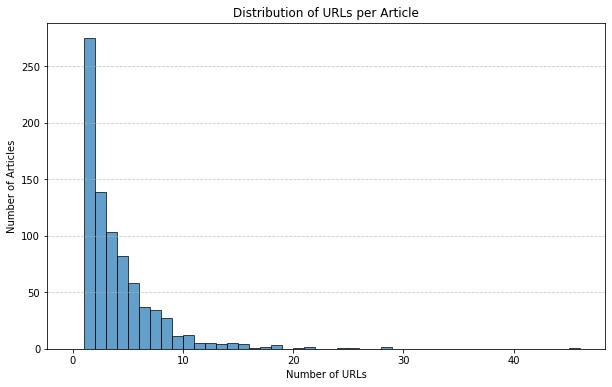

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(url_count_per_doi['URLs'], bins=range(0, url_count_per_doi['URLs'].max() + 1), edgecolor='black', alpha=0.7)
plt.xlabel('Number of URLs')
plt.ylabel('Number of Articles')
plt.title('Distribution of URLs per Article')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<a name='references'></a>
# References

- Lipovský, J. (2022). urlextract: Collects and extracts URLs from given text. (1.8.0) [Python]. https://github.com/lipoja/URLExtract
- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12(85), 2825–2830.
- Sourget, T. (2023). TheoSourget/DDSA_Sourget: Repository used during my travel at the ITU of Copenhagen in March 2023 [Computer software]. https://github.com/TheoSourget/DDSA_Sourget